# ✅ Импорты

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

import numpy as np
import pandas as pd

from sklearn.linear_model import HuberRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Загрузим X5 Retail Hero dataset

In [3]:
DATA_PATH = 'data/retailhero-uplift/data'
SEED = 8

In [4]:
%%time

clients = pd.read_csv(os.path.join(DATA_PATH, 'clients.csv'))
products = pd.read_csv(os.path.join(DATA_PATH, 'products.csv'))
purchases = pd.read_csv(os.path.join(DATA_PATH, 'purchases.csv'))
train = pd.read_csv(os.path.join(DATA_PATH, 'uplift_train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'uplift_test.csv'))

CPU times: user 19.6 s, sys: 5.21 s, total: 24.8 s
Wall time: 26.7 s


## ⚒️ Препроцессинг X5 Retail Hero dataset

In [5]:
%%time

product_cols = ['product_id', 'is_alcohol', 'is_own_trademark']

purchases = purchases.merge(products[product_cols], 
                            on='product_id',
                            how='left'
                           )

purchases['transaction_datetime'] = pd.to_datetime(purchases['transaction_datetime'])

# агрегаты по клиенту:
client_features = purchases.groupby('client_id').agg(
    n_transactions=('transaction_id', 'nunique'),
    sum_trn_sum=('trn_sum_from_iss', 'sum'),
    mean_trn_sum=('trn_sum_from_iss', 'mean'),
    sum_quantity=('product_quantity', 'sum'),
    alcohol_bought=('is_alcohol', 'sum'),
    own_trademark_bought=('is_own_trademark', 'sum'),
    n_unique_products=('product_id', 'nunique'),
    n_days_active=('transaction_datetime', lambda x: x.nunique()),
    last_transaction_days_ago=('transaction_datetime', lambda x: (pd.Timestamp('2019-03-18') - x).max().days)
)

CPU times: user 36.3 s, sys: 1.86 s, total: 38.1 s
Wall time: 38.4 s


In [6]:
%%time

clients['first_issue_date'] = pd.to_datetime(clients['first_issue_date'])
clients['first_redeem_date'] = pd.to_datetime(clients['first_redeem_date'])

clients['issue_ts'] = clients['first_issue_date'].map(pd.Timestamp.timestamp)
clients['redeem_ts'] = clients['first_redeem_date'].apply(
    lambda x: x.timestamp() if pd.notna(x) else np.nan
)

CPU times: user 498 ms, sys: 17.5 ms, total: 516 ms
Wall time: 515 ms


In [7]:
# объединяем с агрегатами:
train_full = train.merge(clients, on='client_id', how='left')
train_full = train_full.merge(client_features, on='client_id', how='left')

test_full = test.merge(clients, on='client_id', how='left')
test_full = test_full.merge(client_features, on='client_id', how='left')

In [8]:
def missing_stats(dataset):
    res = []
    for col in dataset.columns:
        res.append([
            col,
            1.0 - np.mean(dataset[col].isnull()),
            dataset[col].dtype
        ])
    res = pd.DataFrame(res, columns=['feature', 'hitrate', 'dtype'])
    res = res.sort_values(by=['hitrate'], ascending=True)
    res.reset_index(drop=True, inplace=True)
    return res

res_missing = missing_stats(train_full)
res_missing

,feature,hitrate,dtype
0,redeem_ts,0.912287,float64
1,first_redeem_date,0.912287,datetime64[ns]
2,n_unique_products,1.000000,int64
3,own_trademark_bought,1.000000,int64
4,alcohol_bought,1.000000,int64
5,sum_quantity,1.000000,float64
6,mean_trn_sum,1.000000,float64
7,sum_trn_sum,1.000000,float64
8,n_transactions,1.000000,int64
9,client_id,1.000000,object


In [9]:
samples = [train_full, test_full]

to_dt = ['first_issue_date', 'first_redeem_date']

for sample in samples:
    for feat in to_dt:
        sample[feat] = pd.to_datetime(sample[feat], errors='coerce')
        sample[feat] = sample[feat].astype('int64') // 10**9
        sample[to_dt] = sample[to_dt].replace(-9223372036854775808, np.nan).fillna(-1)

fill_mice = res_missing[
                (res_missing['hitrate'] < 1) &
                ~(res_missing['dtype'] == 'object') &
                ~(res_missing['dtype'] == 'datetime64[ns]')
            ]['feature']
fill_mode = res_missing[
                (res_missing['hitrate'] < 1) &
                (res_missing['dtype'] == 'object')
            ]['feature']

for sample in samples:
    imputed = IterativeImputer(
        estimator=HuberRegressor(),
        max_iter=10,
        random_state=SEED
    ).fit_transform(sample[fill_mice])
    sample[fill_mice] = imputed
    sample[fill_mode] = sample[fill_mode].fillna(sample[fill_mode].mode())

In [10]:
train_full['gender'] = train_full['gender'].map({'M': 1, 'F': 0, 'U': -1})
test_full['gender'] = test_full['gender'].map({'M': 1, 'F': 0, 'U': -1})

In [11]:
drop_feat = []

train_full = train_full.drop(drop_feat, axis=1).copy()
test_full = test_full.drop(drop_feat, axis=1).copy()

x_train_ids, x_valid_ids = train_test_split(train_full,
                                            test_size=0.2,
                                            random_state=SEED,
                                            stratify=train_full.treatment_flg.astype(str) +
                                                     train_full.target.astype(str)
                                           )
x_train_ids, x_valid_ids = x_train_ids.index, x_valid_ids.index

train_full.loc[:, 'split'] = None
train_full.iloc[x_train_ids, -1] = 'train'
train_full.iloc[x_valid_ids, -1] = 'valid'

In [12]:
train_full.to_csv(os.path.join(DATA_PATH, 'train_full_preproc.csv'))
test_full.to_csv(os.path.join(DATA_PATH, 'test_full_preproc.csv'))

# ✅ EDA

In [13]:
train_full.shape

(200039, 19)

In [14]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   client_id                  200039 non-null  object 
 1   treatment_flg              200039 non-null  int64  
 2   target                     200039 non-null  int64  
 3   first_issue_date           200039 non-null  int64  
 4   first_redeem_date          200039 non-null  int64  
 5   age                        200039 non-null  int64  
 6   gender                     200039 non-null  int64  
 7   issue_ts                   200039 non-null  float64
 8   redeem_ts                  200039 non-null  float64
 9   n_transactions             200039 non-null  int64  
 10  sum_trn_sum                200039 non-null  float64
 11  mean_trn_sum               200039 non-null  float64
 12  sum_quantity               200039 non-null  float64
 13  alcohol_bought             20

In [15]:
train_full.describe()

,treatment_flg,target,first_issue_date,first_redeem_date,age,gender,issue_ts,redeem_ts,n_transactions,sum_trn_sum,mean_trn_sum,sum_quantity,alcohol_bought,own_trademark_bought,n_unique_products,n_days_active,last_transaction_days_ago
count,200039.000000,200039.000000,2.000390e+05,2.000390e+05,200039.000000,200039.000000,2.000390e+05,2.000390e+05,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000
mean,0.499808,0.619889,1.515492e+09,1.395803e+09,46.417329,-0.296547,1.515492e+09,1.530004e+09,20.120821,8398.786037,75.437531,142.527997,1.916926,17.433061,75.287259,20.120781,96.268868
std,0.500001,0.485415,1.759508e+07,4.331806e+08,49.532475,0.737329,1.759508e+07,1.806356e+07,17.732130,8627.434880,34.422622,140.550727,5.126671,19.139443,56.378792,17.732053,26.991088
min,0.000000,0.000000,1.491330e+09,-1.000000e+00,-7491.000000,-1.000000,1.491330e+09,1.491904e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000
25%,0.000000,0.000000,1.500656e+09,1.510316e+09,34.000000,-1.000000,1.500656e+09,1.514645e+09,8.000000,3096.000000,58.449771,53.000000,0.000000,5.000000,35.000000,8.000000,92.000000
50%,0.000000,1.000000,1.510779e+09,1.525336e+09,45.000000,0.000000,1.510779e+09,1.530004e+09,15.000000,5996.000000,70.309524,104.000000,0.000000,12.000000,62.000000,15.000000,109.000000
75%,1.000000,1.000000,1.529517e+09,1.545776e+09,59.000000,0.000000,1.529517e+09,1.545776e+09,27.000000,10863.000000,85.626551,188.000000,2.000000,23.000000,101.000000,27.000000,113.000000
max,1.000000,1.000000,1.552686e+09,1.574212e+09,1852.000000,1.000000,1.552686e+09,1.574212e+09,320.000000,498973.000000,4427.000000,10614.000000,183.000000,489.000000,1364.000000,320.000000,116.000000


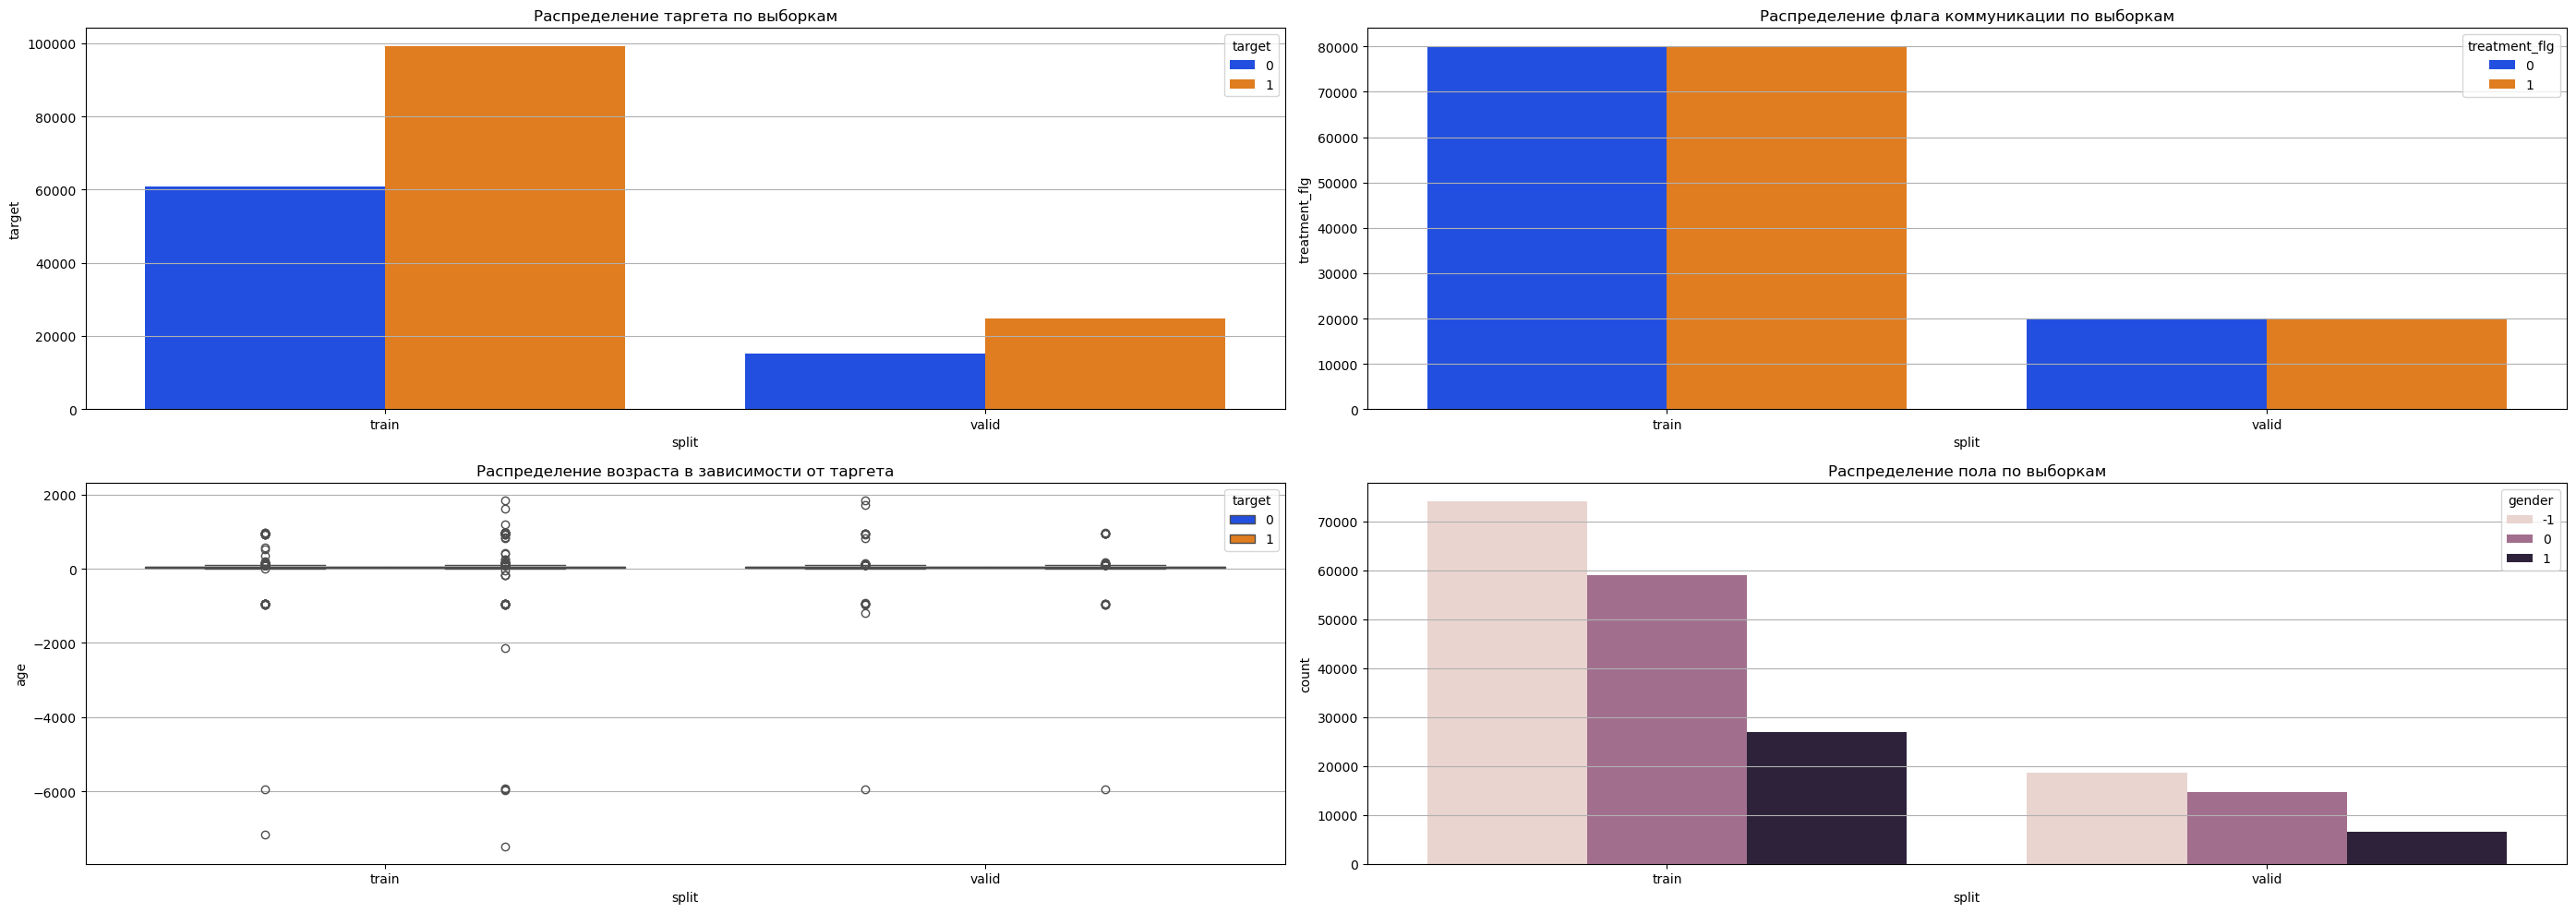

In [16]:
sns.set_palette('bright')

fig, axes = plt.subplots(2, 2, figsize=(28, 10))

sns.barplot(data=train_full, x='split', y='target', hue='target', estimator=len, errorbar=None, ax=axes[0][0])
axes[0][0].set_title('Распределение таргета по выборкам')
axes[0][0].grid(axis='y')

sns.barplot(data=train_full, x='split', y='treatment_flg', hue='treatment_flg', estimator=len, errorbar=None, ax=axes[0][1])
axes[0][1].set_title('Распределение флага коммуникации по выборкам')
axes[0][1].grid(axis='y')

sns.boxplot(data=train_full, x='split', y='age', hue='target', ax=axes[1][0])
axes[1][0].set_title('Распределение возраста в зависимости от таргета')
axes[1][0].grid(axis='y')

sns.countplot(data=train_full, x='split', hue='gender', ax=axes[1][1])
axes[1][1].set_title('Распределение пола по выборкам')
axes[1][1].grid(axis='y')

plt.tight_layout()
plt.show()